# 2:1 MENT

In [1]:
import os
import time

import numpy as np
import psdist as ps
import psdist.plot as psv
import ultraplot as plt

import ment
import ment.train

In [2]:
plt.rc["cmap.discrete"] = False
plt.rc["cmap.sequential"] = "viridis"
plt.rc["colorbar.width"] = "1.2em"
plt.rc["figure.facecolor"] = "white"
plt.rc["grid"] = False

## Settings

In [3]:
dist_name = "galaxy"
ndim = 2
n_meas = 6
n_bins = 80
xmax = 6.0
seed = 0

## Source distribution

In [4]:
dist = ment.dist.get_dist(dist_name, ndim=ndim, seed=seed, normalize=True)
x_true = dist.sample(1_000_000)

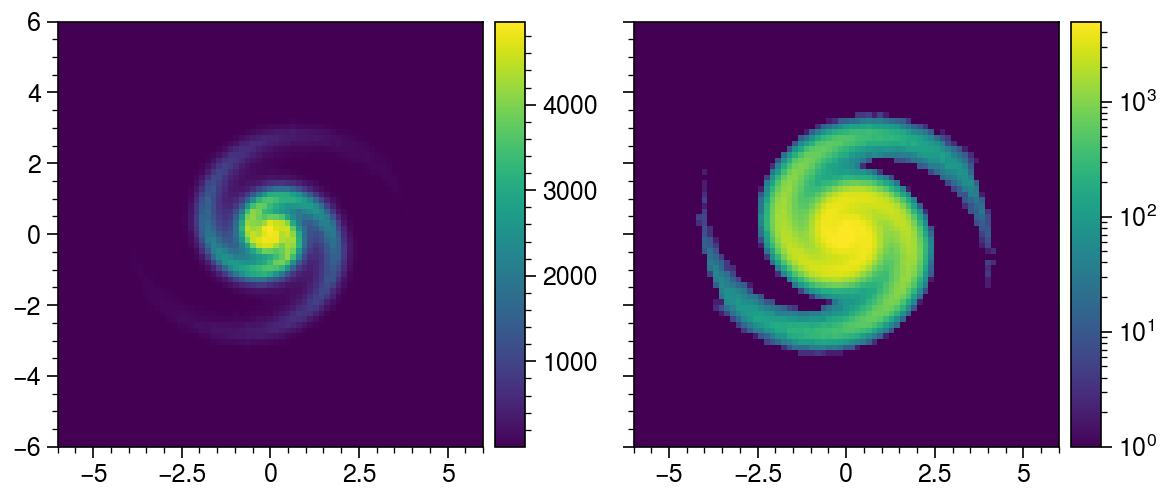

In [5]:
limits = 2 * [(-xmax, xmax)]

fig, axs = plt.subplots(ncols=2, figheight=2.5)
for i, ax in enumerate(axs):
    hist, edges = np.histogramdd(x_true, bins=75, range=limits)
    psv.plot(
        x_true,
        limits=limits,
        bins=75,
        offset=1.0,
        norm=("log" if i else None),
        colorbar=True,
        ax=ax,
    )

## Data generation

In [6]:
phase_advances = np.linspace(0.0, np.pi, n_meas, endpoint=False)

transfer_matrices = []
for phase_advance in phase_advances:
    matrix = ment.sim.rotation_matrix(phase_advance)
    transfer_matrices.append(matrix)

transforms = []
for matrix in transfer_matrices:
    transform = ment.sim.LinearTransform(matrix)
    transforms.append(transform)

bin_edges = np.linspace(-xmax, xmax, n_bins + 1)

diagnostics = []
for transform in transforms:
    diagnostic = ment.Histogram1D(axis=0, edges=bin_edges)
    diagnostics.append([diagnostic])

projections = ment.sim.simulate_with_diag_update(
    x_true,
    transforms,
    diagnostics,
    kde=False,
    blur=0.0,
)

## Reconstruction model

In [7]:
prior = ment.GaussianPrior(ndim=2, scale=1.0)

samp_grid_limits = limits
samp_grid_shape = ndim * [200]
sampler = ment.GridSampler(grid_limits=samp_grid_limits, grid_shape=samp_grid_shape)

integration_limits = [(-xmax, xmax)]
integration_limits = [integration_limits for transform in transforms]
integration_size = 200

model = ment.MENT(
    ndim=ndim,
    transforms=transforms,
    projections=projections,
    prior=prior,
    interpolation_kws=dict(method="linear"),
    sampler=sampler,
    nsamp=1_000_000,
    integration_limits=integration_limits,
    integration_size=integration_size,
    integration_loop=False,  # vectorize integration
    verbose=0,
)

## Training

In [8]:
def plot_model(model):
    figs = []

    # Plot reconstructed vs. true distribution.
    x_pred = model.sample(1_000_000)

    fig, axs = plt.subplots(ncols=2, figheight=2.5)
    for i, ax in enumerate(axs):
        psv.plot(
            x_pred,
            limits=limits,
            bins=128,
            offset=1.0,
            norm=("log" if i else None),
            colorbar=True,
            discrete=False,
            ax=ax,
        )
    figs.append(fig)

    # Plot simulated vs. measured projections.
    projections_true = ment.unravel(model.projections)
    projections_pred = ment.unravel(ment.simulate(x_pred, model.transforms, model.diagnostics))

    ncols = min(n_meas, 7)
    nrows = int(np.ceil(n_meas / ncols))

    for log in [False, True]:
        fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(1.5 * ncols, 1.25 * nrows))
        for index in range(len(projections_true)):
            ax = axs[index]
            proj_true = projections_true[index]
            proj_pred = projections_pred[index]
            scale = np.max(proj_true.values)
            ax.plot(proj_true.coords, proj_true.values / scale, color="lightgray")
            ax.plot(
                proj_pred.coords, proj_pred.values / scale, color="black", marker=".", lw=0, ms=1.0
            )
            ax.format(ymax=1.25, xlim=(-xmax, xmax))
            if log:
                ax.format(yscale="log", ymax=5.0, ymin=1.00e-05, yformatter="log")
        figs.append(fig)

    return figs

non numeric history values being saved


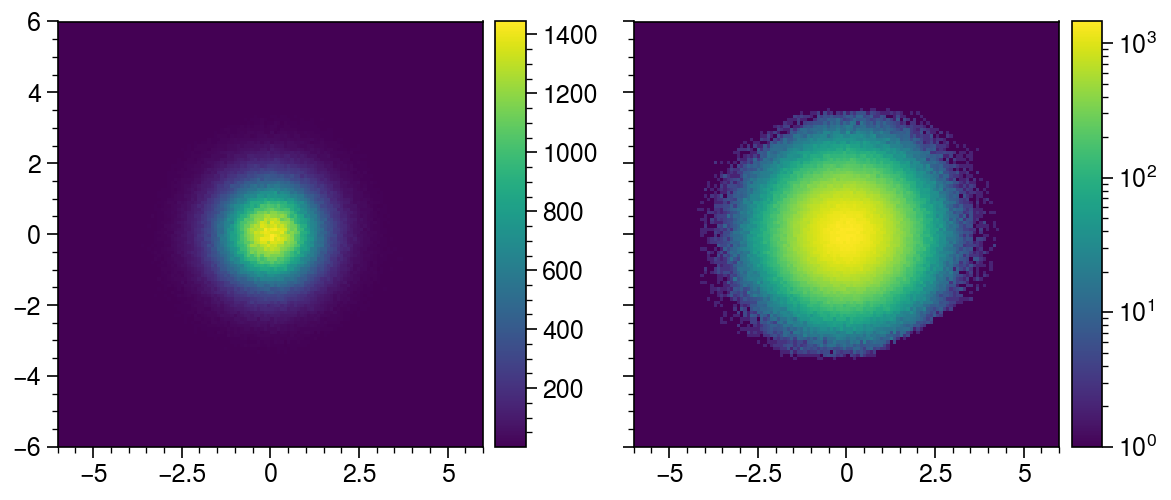

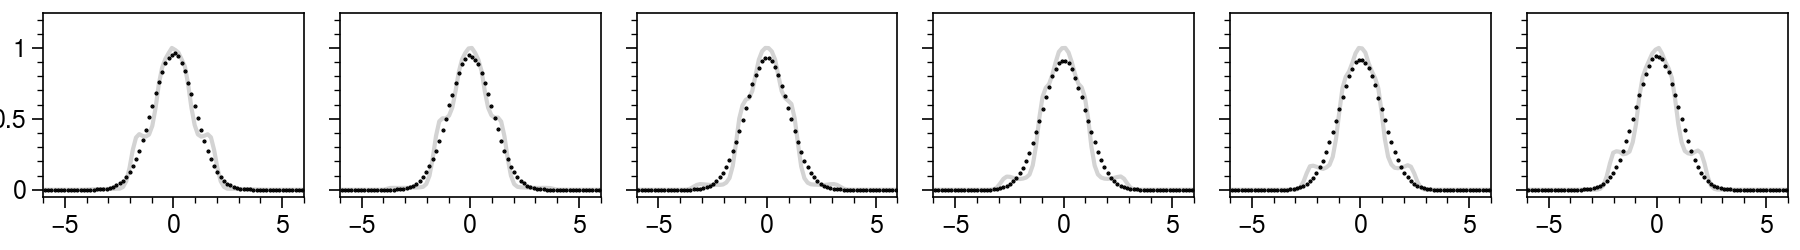

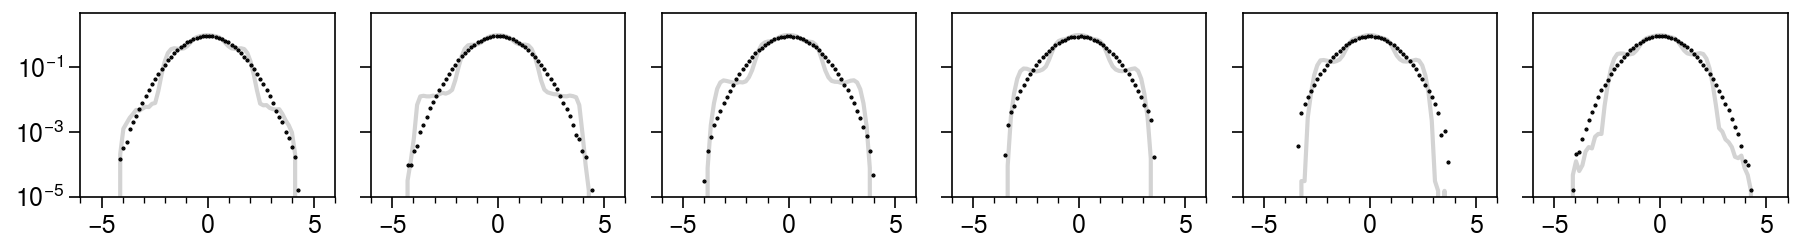

{'cov_matrix': array([[1.0010776 , 0.00655869],
       [0.00655869, 0.98652086]]),
 'discrepancy': np.float64(0.013158861111111154)}
epoch = 1


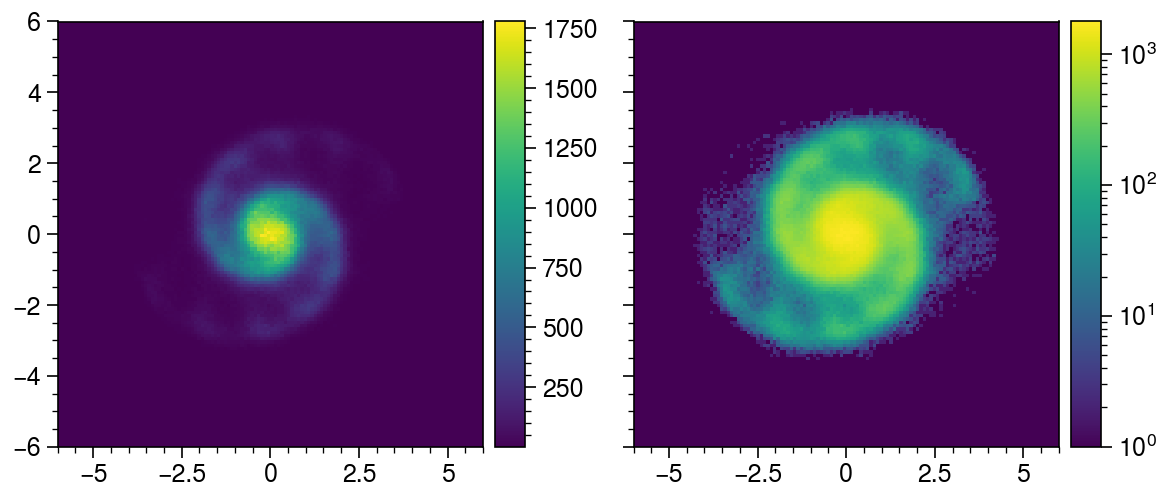

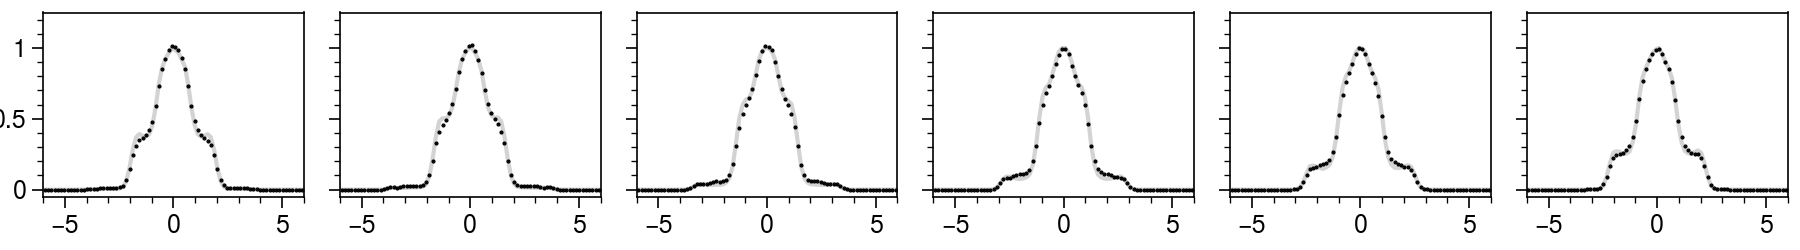

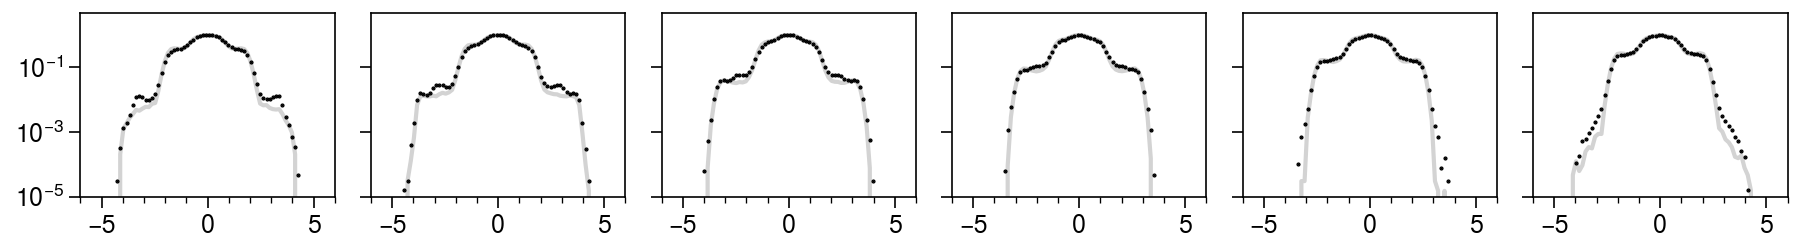

{'cov_matrix': array([[ 1.01893555e+00, -9.71631735e-04],
       [-9.71631735e-04,  1.07247779e+00]]),
 'discrepancy': np.float64(0.004508750000000017)}
epoch = 2


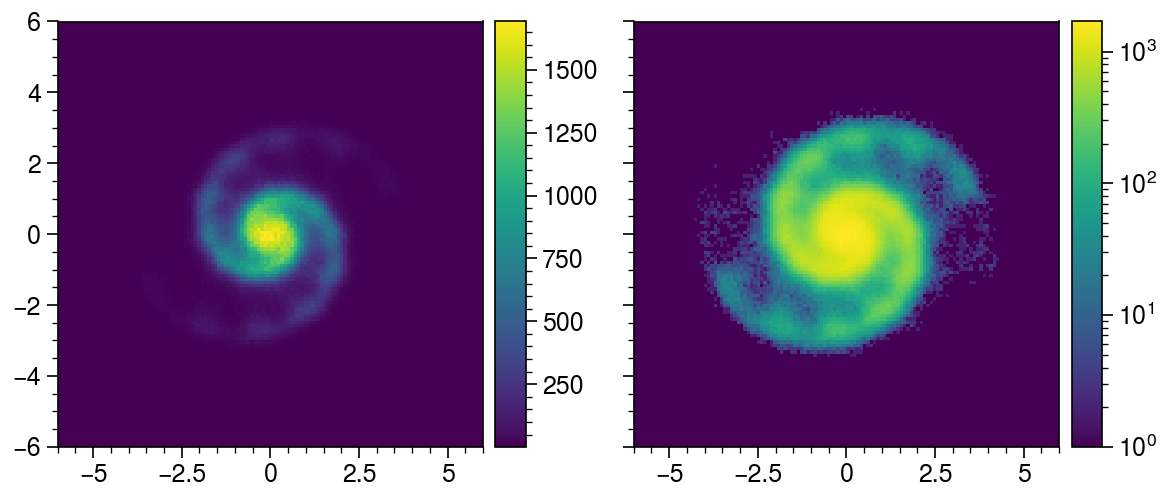

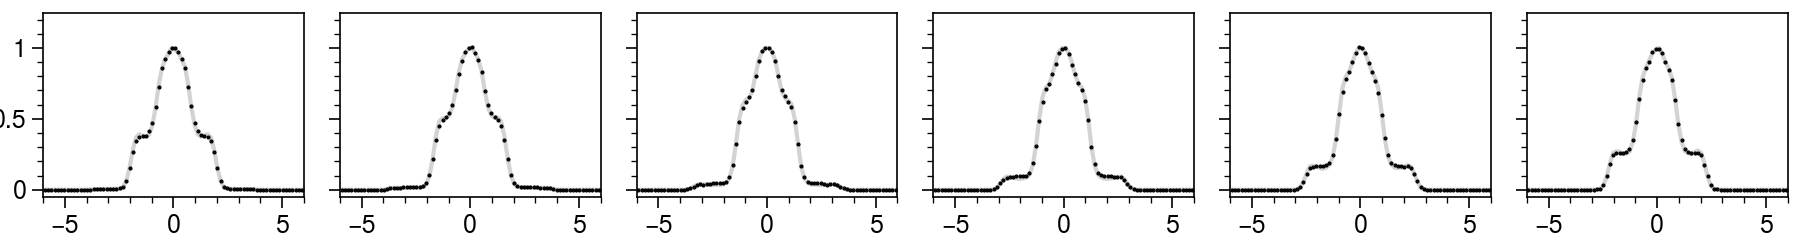

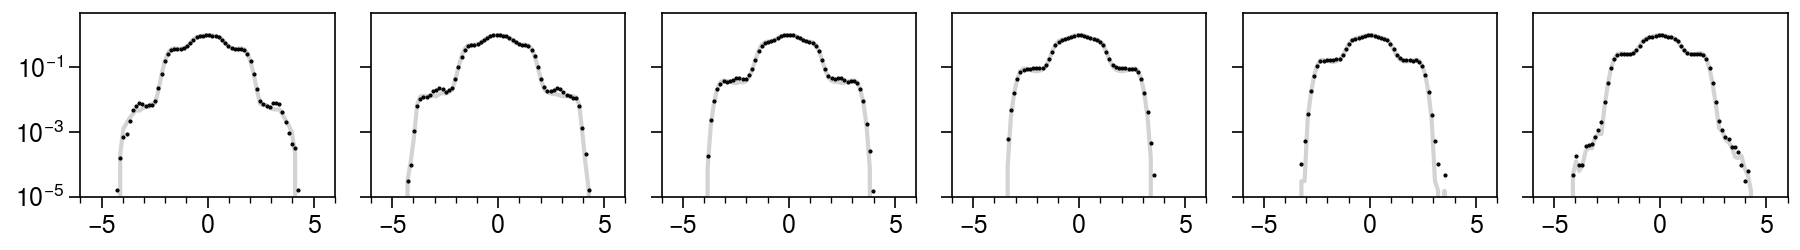

{'cov_matrix': array([[ 1.00633118, -0.02327529],
       [-0.02327529,  1.02981997]]),
 'discrepancy': np.float64(0.0023219166666666757)}
epoch = 3


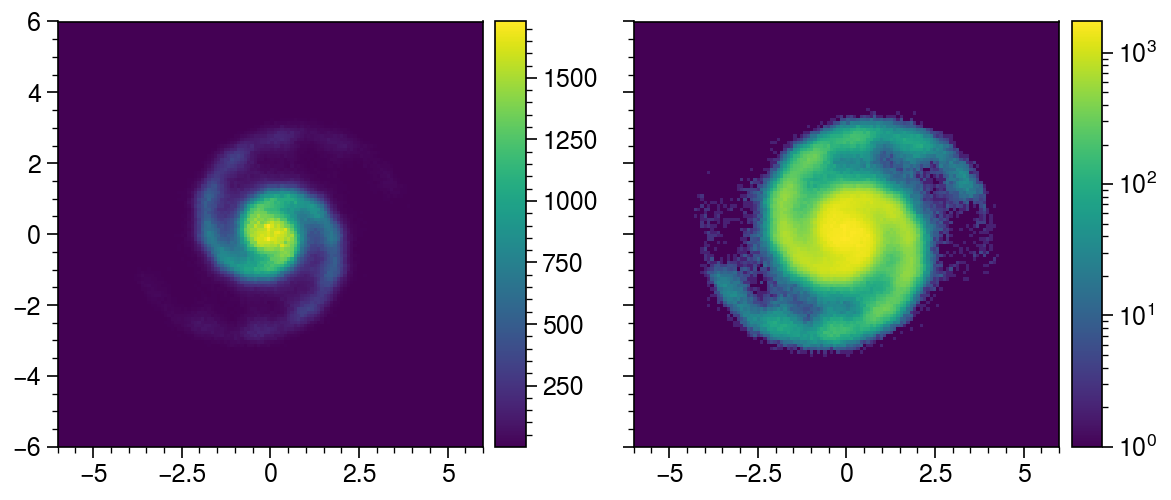

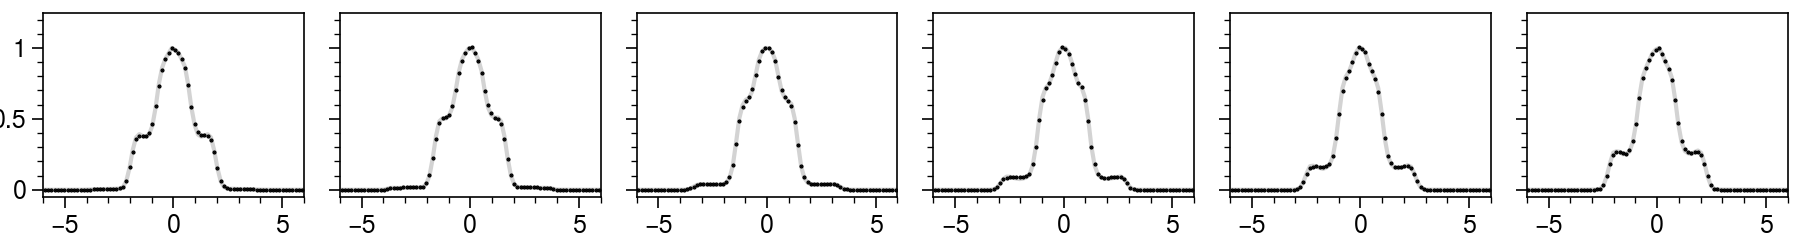

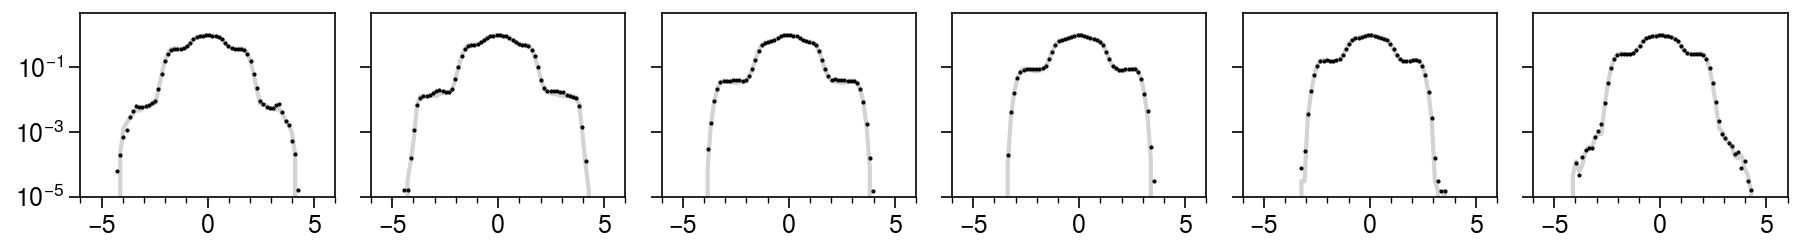

{'cov_matrix': array([[ 1.00467517, -0.03320002],
       [-0.03320002,  1.02207586]]),
 'discrepancy': np.float64(0.0018934722222222298)}
epoch = 4


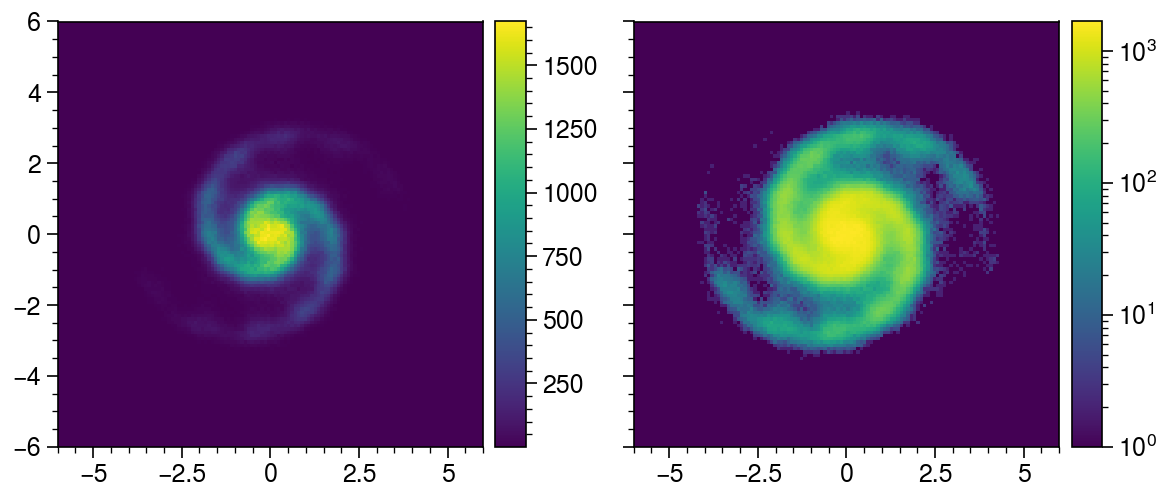

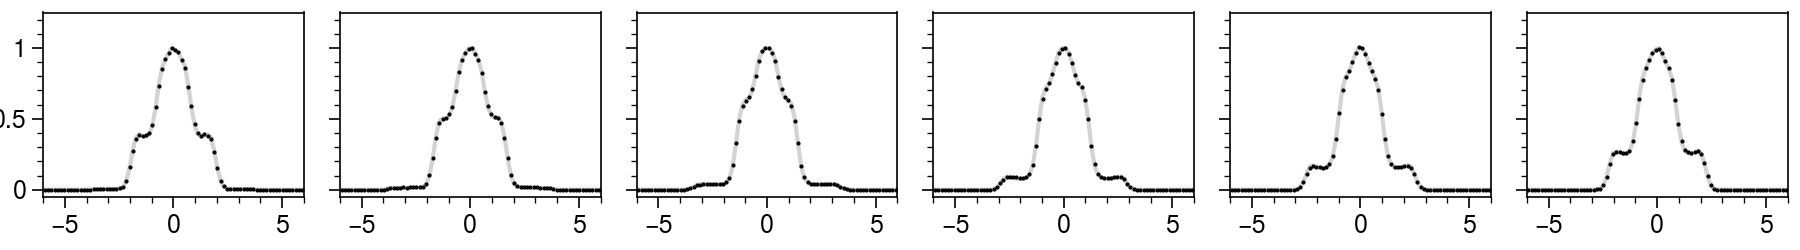

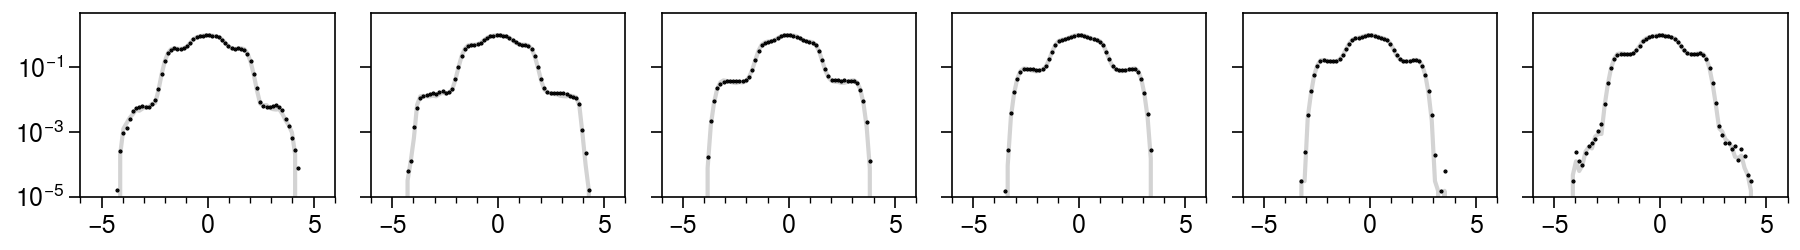

{'cov_matrix': array([[ 1.00931116, -0.0347517 ],
       [-0.0347517 ,  1.00886634]]),
 'discrepancy': np.float64(0.0014746666666666719)}


In [9]:
model.mode = "integrate"

trainer = ment.train.Trainer(
    model,
    plot_func=plot_model,
    eval_func=ment.train.Evaluator(nsamp=100_000),
    notebook=True,
)

trainer.train(epochs=4, learning_rate=0.75)